In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import os
import datetime

In [5]:
""" Load dataframes from other notebooks """
%store -r df_inflation
%store -r df_interest

In [6]:
""" Chart variables """
start_date = pd.to_datetime('1960-01-01')
end_date = pd.to_datetime('2025-01-01') # used to force chart to plot to end of 5 year period
df_interest = df_interest.loc[df_interest.index >= start_date]
df_inflation = df_inflation.loc[df_inflation.index >= start_date]
interest_column = 'FILRHLBVS'
inflation_column = 'GCPIAGYP'
# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df_interest[interest_column].last_valid_index()

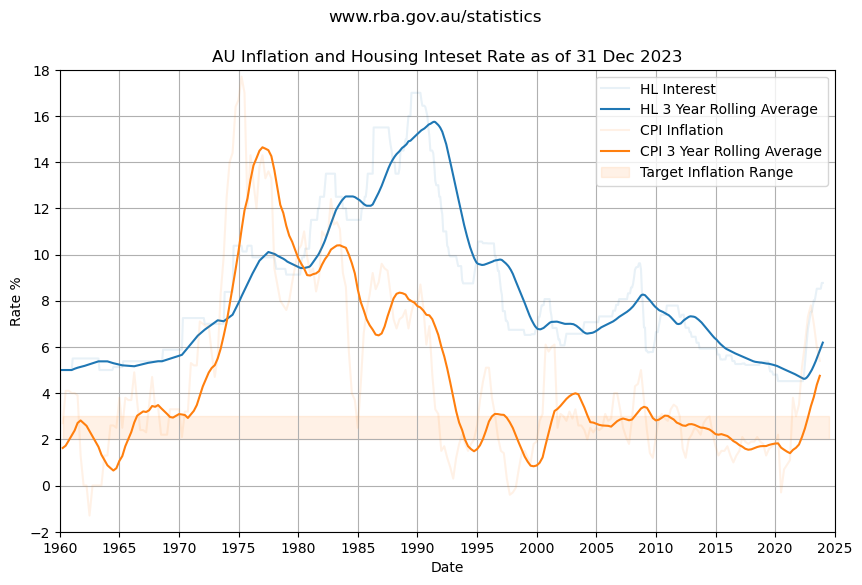

In [7]:
plt.figure(figsize=(10, 6))
colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df_interest.index, df_interest[interest_column], label='HL Interest', color=colors[0]['color'], alpha=0.1)
plt.plot(df_interest.index, df_interest['3_yr_rolling'], label='HL 3 Year Rolling Average',color=colors[0]['color'])
plt.plot(df_inflation.index, df_inflation[inflation_column], label='CPI Inflation', color=colors[1]['color'], alpha=0.1)
plt.plot(df_inflation.index, df_inflation['3_yr_rolling'], label='CPI 3 Year Rolling Average', color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Inflation and Housing Inteset Rate as of ' + last_index.strftime('%d %b %Y'))
plt.grid(True)
plt.xlim(left=start_date, right=end_date)
plt.ylim(bottom=-2, top=18) 
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set major ticks every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

# Add a horizontal band between y=2 and y=3
plt.fill_between(df_inflation.index, 2, 3, color=colors[1]['color'], alpha=0.1)
# Create a Patch for the legend
target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
# Get the existing legend entries
handles, labels = ax.get_legend_handles_labels()
# Add the patch to the existing handles
handles.append(target_range)
# Create the legend with the existing entries and the new patch
plt.legend(handles=handles, loc='best')

plt.savefig(os.path.join('..', 'inflation-and-interest-rates.png'), bbox_inches='tight')
plt.show()